In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## The goal of this project is to **predict** the prices of houses in Boston.

 #### The data is available in Keras with the name 'boston_housing'. 



In [2]:
from keras.datasets import boston_housing
from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


![](https://i.imgur.com/KFVsJqU.jpg)

This dataset consists of 506 samples with 13 features, where 404 samples are for training data and 102 samples are for testing data.
## load dataset

In [3]:
(train_data,train_targets),(test_data,test_targets) = boston_housing.load_data()
test_data.shape , train_data.shape

57026/57026 [==============================] - 0s 0us/step


((102, 13), (404, 13))

# Preparing the data(Normalized Data)
![](https://i.imgur.com/ta3W0GO.jpg)
### The Standardization method is used to normalize data using the numpy library

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

## BUILDING THE NETWORK

Because we’ll need to instantiate the same model multiple times, we use a function to construct it.

![](https://i.imgur.com/D9Euc6x.jpg)

### The loss MSE and metric function is MAE

In [5]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

To evaluate the network after its parameters are set, data can be divided into training and validation sets.

### The best validation method is K-fold Cross-validation .

#### We use this method to evaluate the network

In [6]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [7]:
print(all_scores)
np.mean(all_scores)

[2.0185325145721436, 2.5930027961730957, 2.7784016132354736, 2.3059370517730713]


2.423968493938446

"The different results indicate various validation score outcomes. They range from 2.1 to 2.8, with an average of 2.5, which is a more reliable metric than an individual score."

## Longer training (epochs 500) of network and storage score validation at the end of each epoch

In [9]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
    validation_data=(val_data, val_targets),
    epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


#### We can then compute the average of the per-epoch MAE scores for all folds

In [13]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### Plotting validation scores

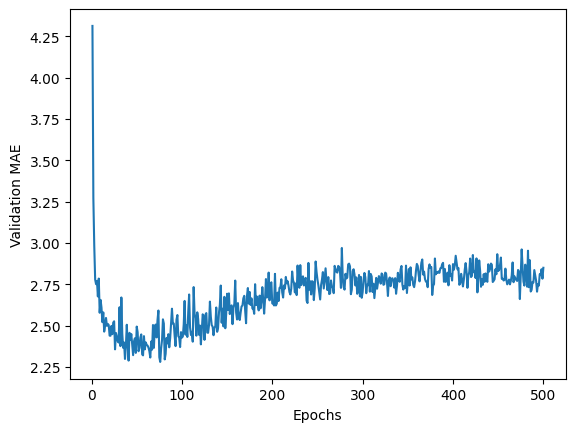

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### Drawing credit scores at different intervals for better viewing

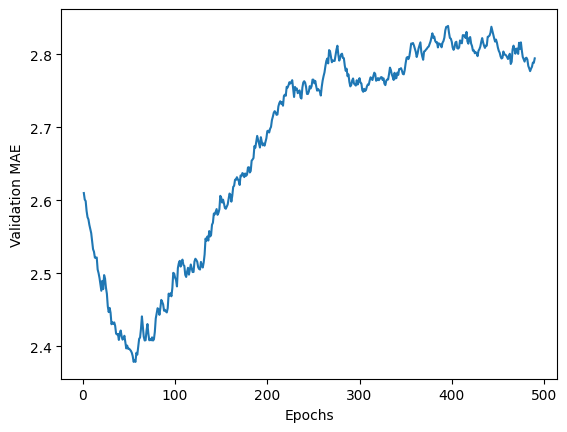

In [15]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Omit the first 10 data points, which are on a different scale than the rest of the curve.

Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

### As is evident after 80 epochs Overfiting occurs
# Training the final model

In [16]:
model = build_model() 
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 16.8613 - mae: 2.5032


### Here’s the final result:

In [17]:
test_mae_score

2.5032033920288086

### We’re still off by about $2,50.